In [13]:
import pickle
import networkx as nx       
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr
from sklearn.decomposition import PCA
from networkx.algorithms import community

In [14]:
G = pickle.load(open('../data/ex_2_graph.pickle', 'rb'))
print("edges: ", G.number_of_edges())
print("nodes: ", G.number_of_nodes())

assignees = pd.read_csv("../data/ex_2_assignments.csv")
print("\n")
print(assignees.head())


### Dataset Exploration
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is directed: {G.is_directed()}")
print(f"Graph density: {nx.density(G):.2f}")

print("\n")

# List all unique node attribute keys
all_node_attrs = set()
for node in G.nodes():
    all_node_attrs.update(G.nodes[node].keys())
print(f"All available node attributes: {sorted(all_node_attrs)}")

# List all unique edge attribute keys
all_edge_attrs = set()
for u, v in G.edges():
    all_edge_attrs.update(G.edges[u, v].keys())
print(f"All available edge attributes: {sorted(all_edge_attrs)}")

print("\n")

# Example: first node and all its at tributes
first_node = list(G.nodes())[0]
print(f"Example node: {first_node}")
print(f"Node attributes: {G.nodes[first_node]}")

# Example: first edge and all its attributes
first_edge = list(G.edges())[0]
print(f"Example edge: {first_edge}")
print(f"Edge attributes: {G.edges[first_edge]}")

print("\n")

print(f"Graph attributes: {dict(G.graph)}")

degrees = [G.degree(n) for n in G.nodes()]
print(f"Degree - Min: {min(degrees)}, Max: {max(degrees)}, Mean: {np.mean(degrees):.2f}")
if nx.is_connected(G):
    print(f"Avg shortest path: {nx.average_shortest_path_length(G):.2f}")

edges:  1084
nodes:  100


   node_id new_faction
0       72      Caesar
1       92      Caesar
2       94      Pompey
3       68      Caesar
4       84      Caesar
Number of nodes: 100
Number of edges: 1084
Is directed: False
Graph density: 0.22


All available node attributes: ['faction']
All available edge attributes: ['meetings']


Example node: 0
Node attributes: {'faction': 'Caesar'}
Example edge: (0, 1)
Edge attributes: {'meetings': 30}


Graph attributes: {}
Degree - Min: 9, Max: 35, Mean: 21.68
Avg shortest path: 1.83


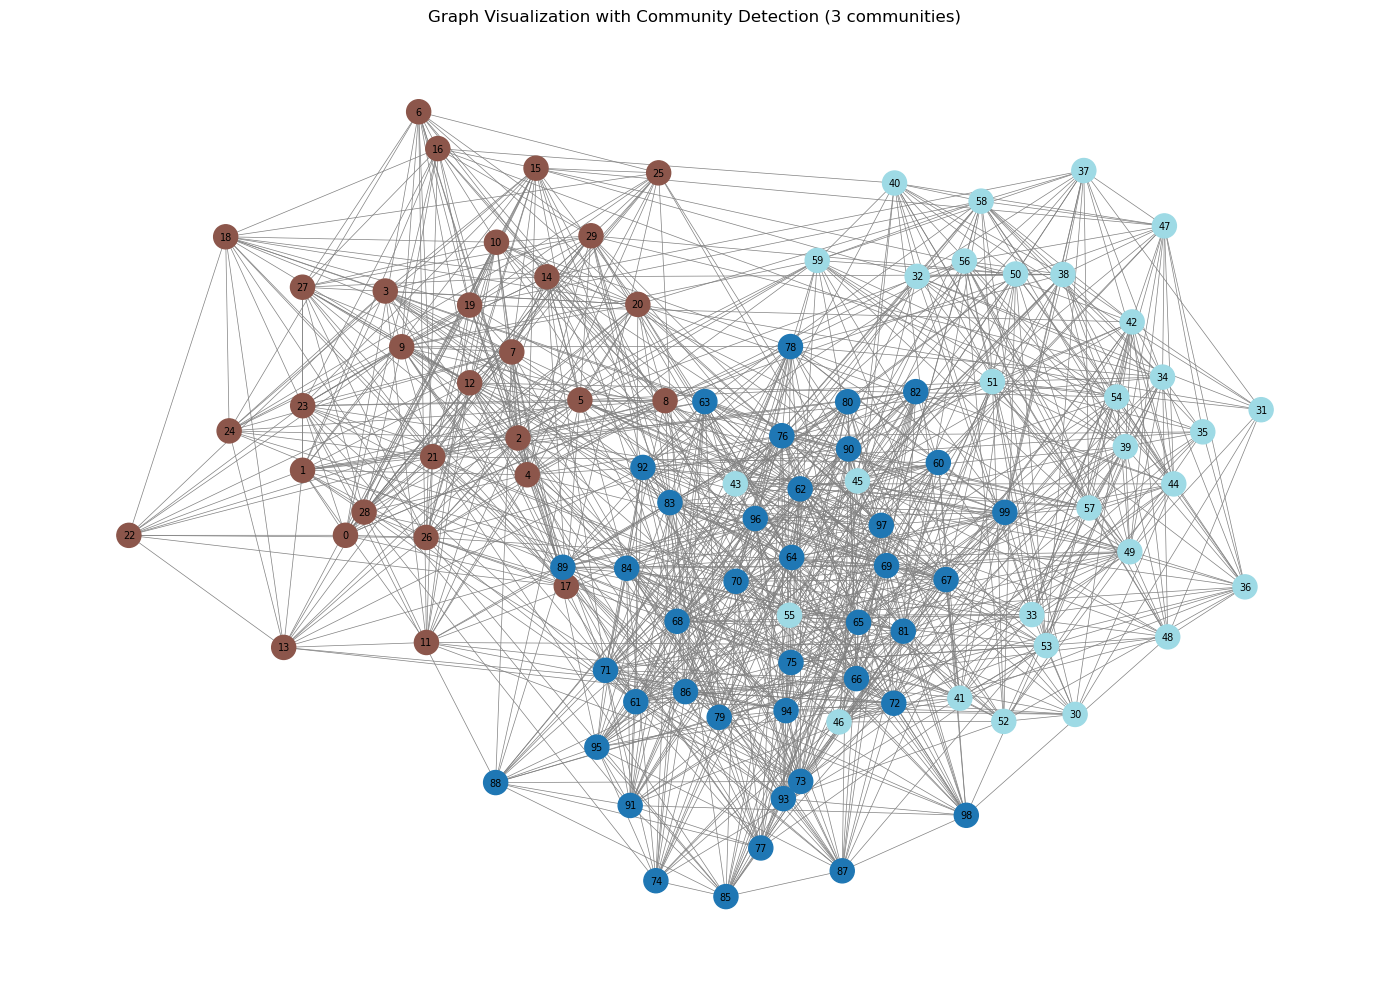

In [15]:
communities = list(community.greedy_modularity_communities(G))
color_map = [0] * len(G)
for i, comm in enumerate(communities):
    for node in comm:
        color_map[node] = i

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=1, iterations=50)
nx.draw_networkx(G, pos, node_color=color_map, cmap='tab20', 
                 node_size=300, with_labels=True, font_size=7, edge_color='gray', width=0.5)
plt.title(f"Graph Visualization with Community Detection ({len(communities)} communities)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
# Prepare edge data with meeting weights (consistent with ex1 naming convention)
edges = np.array(list(G.edges()))
nodes_list = list(G.nodes())
node_to_idx = {node: idx for idx, node in enumerate(nodes_list)}

# Convert edges to indices and extract meeting counts
edge_indices = np.array([[node_to_idx[u], node_to_idx[v]] for u, v in edges])
edge_meetings = np.array([G.edges[u, v]['meetings'] for u, v in edges])

n_nodes = len(nodes_list)

# Prepare faction and weighted degree data for visualization
factions = {}
for node in G.nodes():
    factions[node] = G.nodes[node]['faction']

weighted_degree = {node: sum(G[node][neighbor]['meetings'] for neighbor in G[node]) for node in G.nodes()}

print(f"Edge meetings - Min: {edge_meetings.min()}, Max: {edge_meetings.max()}, Mean: {edge_meetings.mean():.2f}")
print(f"Weighted degree - Min: {min(weighted_degree.values())}, Max: {max(weighted_degree.values())}, Mean: {np.mean(list(weighted_degree.values())):.2f}")
print(f"\nFaction distribution:")
for faction in ['Caesar', 'Pompey', 'Crassus']:
    count = sum(1 for f in factions.values() if f == faction)
    print(f"  {faction}: {count} politicians")

Edge meetings - Min: 1, Max: 45, Mean: 20.50
Weighted degree - Min: 225, Max: 727, Mean: 444.38

Faction distribution:
  Caesar: 30 politicians
  Pompey: 30 politicians
  Crassus: 40 politicians


Faction Counts:
new_faction
Caesar    10
Pompey    10
Name: count, dtype: int64

Caesar gathered more politicians: 10 vs 10


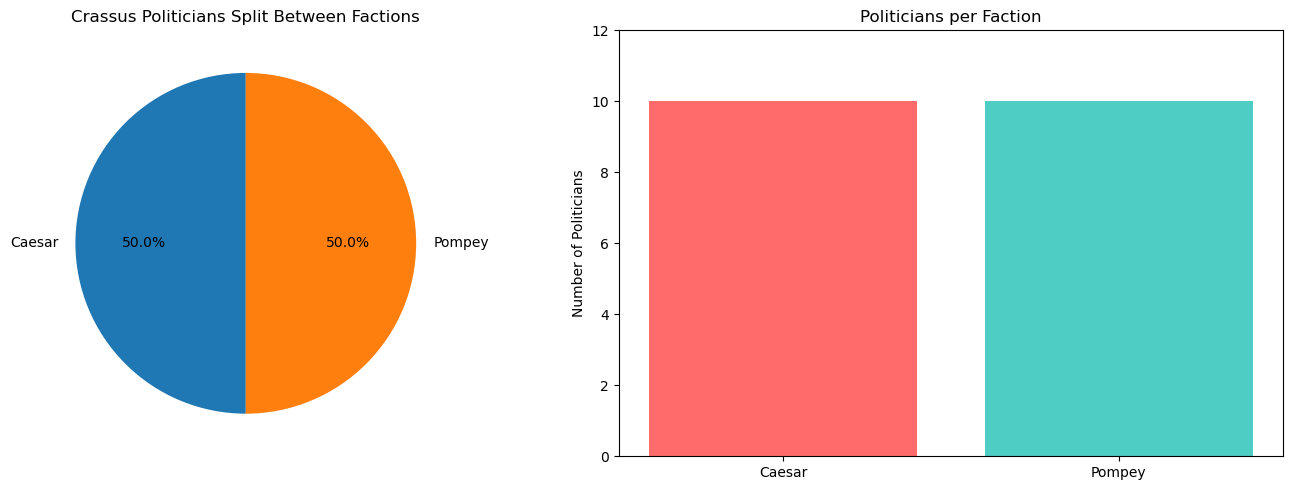

In [17]:
# Question 1: Who gathered more politicians from Crassus' faction?

# Count assignments to each faction
faction_counts = assignees['new_faction'].value_counts()
print("Faction Counts:")
print(faction_counts)
print(f"\n{faction_counts.idxmax()} gathered more politicians: {faction_counts.max()} vs {faction_counts.min()}")

# Visualize the split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie(faction_counts.values, labels=faction_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Crassus Politicians Split Between Factions')

# Bar chart
axes[1].bar(faction_counts.index, faction_counts.values, color=['#FF6B6B', '#4ECDC4'])
axes[1].set_ylabel('Number of Politicians')
axes[1].set_title('Politicians per Faction')
axes[1].set_ylim(0, max(faction_counts.values) * 1.2)

plt.tight_layout()
plt.show()


Politicians ranked by degree centrality:
    node_id new_faction  degree_centrality  betweenness_centrality  degree
3        68      Caesar           0.353535                0.015361      35
5        70      Pompey           0.343434                0.021232      34
2        94      Pompey           0.313131                0.011539      31
15       65      Caesar           0.292929                0.010607      29
14       76      Pompey           0.292929                0.013804      29
6        69      Pompey           0.282828                0.011603      28
12       83      Caesar           0.282828                0.010883      28
11       67      Caesar           0.272727                0.008853      27
9        86      Pompey           0.272727                0.014675      27
1        92      Caesar           0.252525                0.011286      25


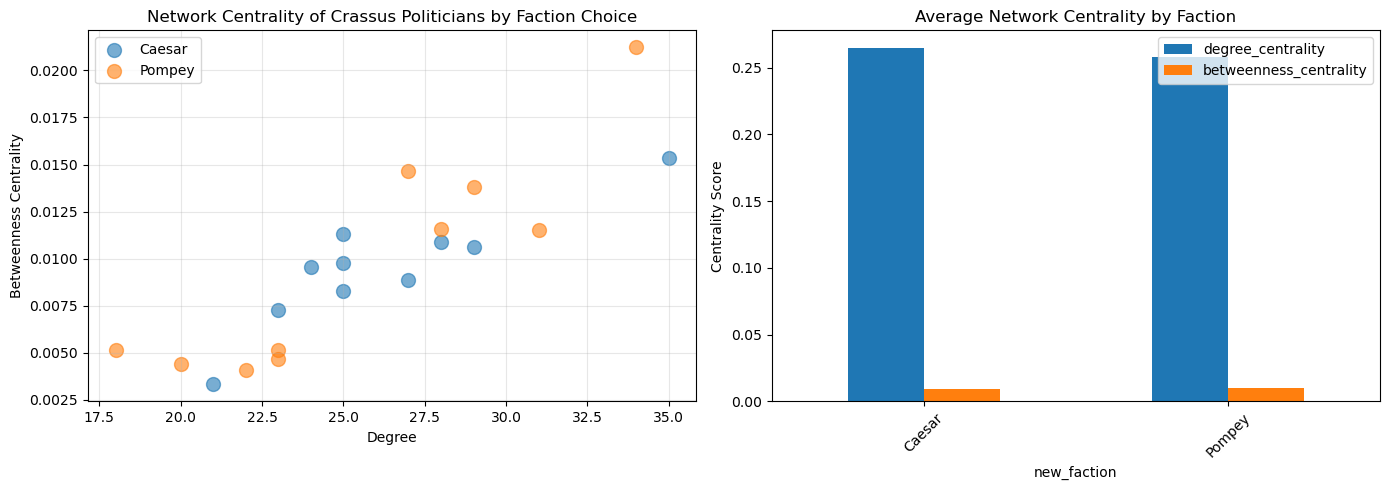

In [18]:
# Analyze network properties of the politicians
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Create dataframe with politician info
politician_analysis = assignees.copy()
politician_analysis['degree_centrality'] = politician_analysis['node_id'].map(degree_centrality)
politician_analysis['betweenness_centrality'] = politician_analysis['node_id'].map(betweenness_centrality)
politician_analysis['degree'] = politician_analysis['node_id'].map(dict(G.degree()))

print("Politicians ranked by degree centrality:")
print(politician_analysis.sort_values('degree_centrality', ascending=False).head(10))

# Visualize: are high-centrality politicians influential in faction choice?
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: degree vs faction
for faction in politician_analysis['new_faction'].unique():
    data = politician_analysis[politician_analysis['new_faction'] == faction]
    axes[0].scatter(data['degree'], data['betweenness_centrality'], label=faction, s=100, alpha=0.6)

axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Betweenness Centrality')
axes[0].set_title('Network Centrality of Crassus Politicians by Faction Choice')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Average centrality by faction
avg_centrality = politician_analysis.groupby('new_faction')[['degree_centrality', 'betweenness_centrality']].mean()
avg_centrality.plot(kind='bar', ax=axes[1])
axes[1].set_title('Average Network Centrality by Faction')
axes[1].set_ylabel('Centrality Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [19]:
# Weighted Bayesian Latent Space Model (consistent with ex1)
# P(meetings_ij) = Poisson(lambda = exp(alpha - beta * ||z_i - z_j||))
# This models the MEETING COUNT as a function of distance in latent space

latent_dim = 2  # Dimension of node embeddings (R^2 for interpretability)

with pm.Model() as model:
    # Prior: Scaled Normal for latent positions
    z = pm.Normal('z', mu=0, sigma=1.0, shape=(n_nodes, latent_dim))
    
    # Global intercept (baseline meeting rate)
    alpha = pm.Normal('alpha', mu=np.log(edge_meetings.mean()), sigma=1.0)
    
    # Distance scale parameter (positive) - Half-Normal prior
    beta = pm.HalfNormal('beta', sigma=1.0)
    
    # Compute Euclidean distances for all observed edges
    z_i = z[edge_indices[:, 0]]  # Shape: (num_edges, latent_dim)
    z_j = z[edge_indices[:, 1]]  # Shape: (num_edges, latent_dim)
    distances = pm.math.sqrt(pm.math.sum((z_i - z_j)**2, axis=1))  # Euclidean distance
    
    # Log-link: lambda = exp(alpha - beta * distance)
    # Smaller distance (closer in latent space) = more meetings
    log_lambda = alpha - beta * distances
    
    # Likelihood: Poisson distribution for meeting counts
    meetings_obs = pm.Poisson('meetings_obs', mu=pm.math.exp(log_lambda), observed=edge_meetings)
    
    print("Weighted model created. Starting inference...")
    # MCMC inference
    trace = pm.sample(
        draws=7500,
        tune=3000,
        cores=6,
        chains=6,
        random_seed=42,
        progressbar=True,
        return_inferencedata=True,
        target_accept=0.95  # Conservative sampling
    )

print("Inference completed!")
print("\nModel incorporates meeting weights!")
print(f"Edges are weighted by meeting counts (range: {edge_meetings.min()}-{edge_meetings.max()})")
print("\nConvergence Summary:")
summary = az.summary(trace, var_names=['z', 'alpha', 'beta'])
print(summary.head(15))

Weighted model created. Starting inference...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [z, alpha, beta]


Output()

Sampling 6 chains for 3_000 tune and 7_500 draw iterations (18_000 + 45_000 draws total) took 281 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference completed!

Model incorporates meeting weights!
Edges are weighted by meeting counts (range: 1-45)

Convergence Summary:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
z[0, 0]  0.026  0.928  -1.404    1.435      0.080    0.016     151.0   
z[0, 1]  0.157  0.991  -1.406    1.478      0.105    0.021     102.0   
z[1, 0]  0.026  1.083  -1.655    1.629      0.094    0.019     151.0   
z[1, 1]  0.183  1.154  -1.640    1.702      0.124    0.025     101.0   
z[2, 0]  0.023  1.163  -1.755    1.761      0.100    0.020     152.0   
z[2, 1]  0.193  1.242  -1.757    1.819      0.134    0.026      99.0   
z[3, 0]  0.002  0.993  -1.576    1.537      0.083    0.017     158.0   
z[3, 1]  0.145  1.053  -1.563    1.618      0.114    0.021      98.0   
z[4, 0]  0.023  0.950  -1.450    1.461      0.082    0.016     152.0   
z[4, 1]  0.160  1.013  -1.455    1.503      0.108    0.021     102.0   
z[5, 0]  0.014  0.965  -1.466    1.472      0.082    0.016     155.0   
z[5, 

Learned embeddings shape: (100, 2)
Embedding statistics:
  Mean: 0.0007
  Std: 0.0913

Ranges for Dimensions in R^2 latent space:
  Dimension 1 range: [-0.08, 0.12]
  Dimension 2 range: [-0.15, 0.21]


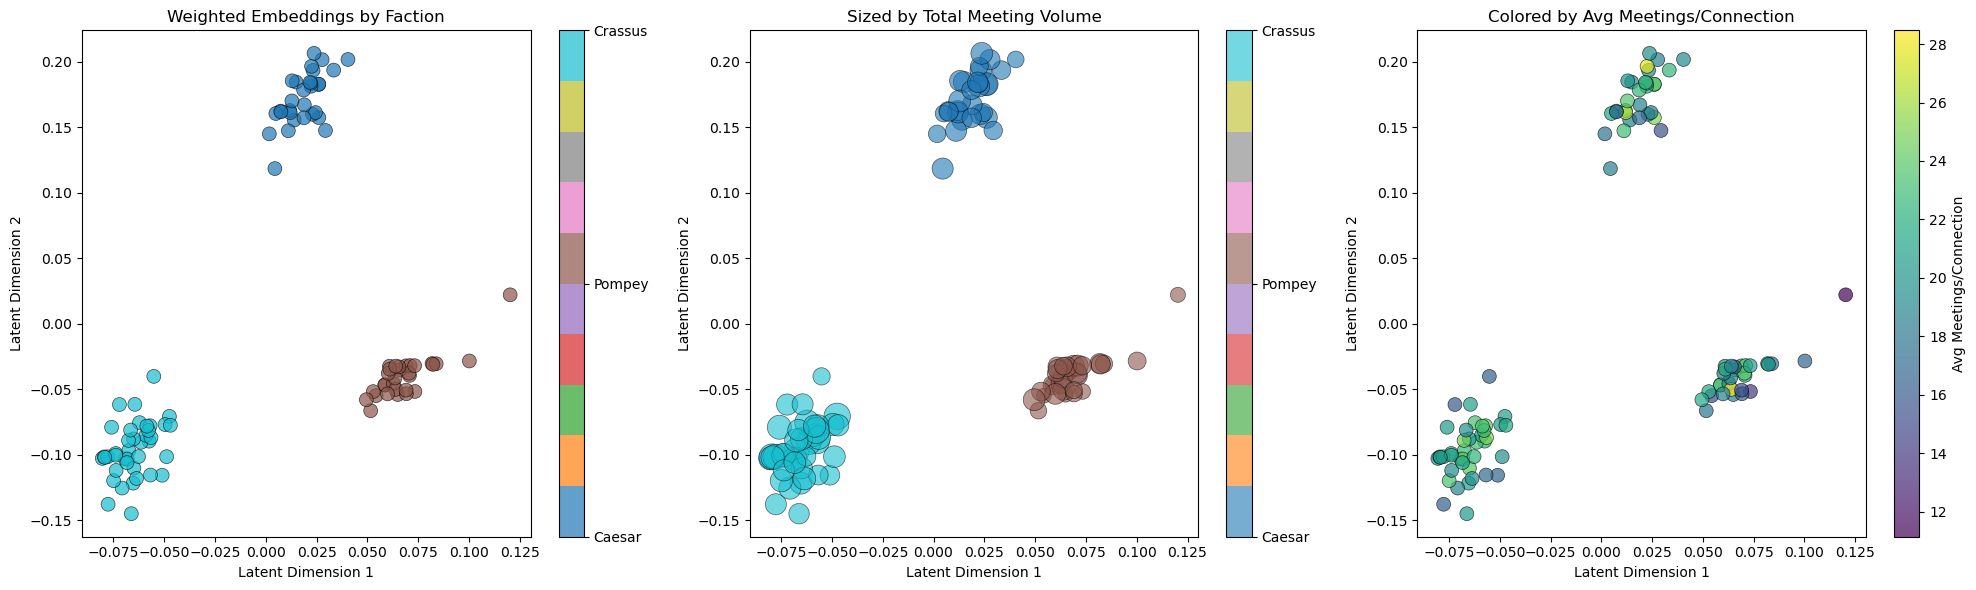

In [20]:
# Extract learned embeddings (posterior mean)
z_posterior = trace.posterior['z'].mean(dim=['chain', 'draw']).values

print(f"Learned embeddings shape: {z_posterior.shape}")
print(f"Embedding statistics:\n  Mean: {z_posterior.mean():.4f}\n  Std: {z_posterior.std():.4f}")

z_2d = z_posterior

print(f"\nRanges for Dimensions in R^{latent_dim} latent space:")
print(f"  Dimension 1 range: [{z_2d[:, 0].min():.2f}, {z_2d[:, 0].max():.2f}]")
print(f"  Dimension 2 range: [{z_2d[:, 1].min():.2f}, {z_2d[:, 1].max():.2f}]")

# Calculate average meeting volume for each node
node_avg_meetings = {}
for node in G.nodes():
    total_meetings = sum(G[node][neighbor]['meetings'] for neighbor in G[node])
    node_avg_meetings[node] = total_meetings / G.degree(node)

# Create visualization comparing embeddings with actual meeting patterns
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Embeddings colored by faction
ax = axes[0]
node_factions = [factions[nodes_list[i]] for i in range(len(nodes_list))]
faction_colors_map = {'Caesar': 0, 'Pompey': 1, 'Crassus': 2}
faction_colors = [faction_colors_map[f] for f in node_factions]
scatter1 = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=faction_colors, s=100, 
                      cmap='tab10', alpha=0.7, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Weighted Embeddings by Faction')
cbar = plt.colorbar(scatter1, ax=ax, ticks=[0, 1, 2])
cbar.set_ticklabels(['Caesar', 'Pompey', 'Crassus'])

# Plot 2: Embeddings sized by total meeting volume
ax = axes[1]
total_meetings_per_node = [weighted_degree[nodes_list[i]] for i in range(len(nodes_list))]
scatter2 = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=faction_colors, 
                      s=np.array(total_meetings_per_node) / 2, 
                      cmap='tab10', alpha=0.6, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Sized by Total Meeting Volume')
cbar2 = plt.colorbar(scatter2, ax=ax, ticks=[0, 1, 2])
cbar2.set_ticklabels(['Caesar', 'Pompey', 'Crassus'])

# Plot 3: Embeddings colored by average meetings per connection
ax = axes[2]
avg_meetings_per_node = [node_avg_meetings[nodes_list[i]] for i in range(len(nodes_list))]
scatter3 = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=avg_meetings_per_node, s=100, 
                      cmap='viridis', alpha=0.7, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Colored by Avg Meetings/Connection')
plt.colorbar(scatter3, ax=ax, label='Avg Meetings/Connection')

plt.tight_layout()
plt.show()

## Exercise 2, Question 2: Most Undecided Politicians

**Who are the most undecided politicians when it comes to choosing between Caesar and Pompey?**

To identify undecided politicians from Crassus faction, we analyze:
1. **Distance from faction centroids in latent space**: Undecided politicians should be equidistant from both Caesar and Pompey centroids
2. **Balance of connections**: Equal number of connections/meetings to both factions
3. **Embedding position**: Located near the boundary between the two factions

We use the **meetings** edge attribute to weight the importance of connections - politicians with more meetings to both factions are more engaged and their indecision is more significant.

In [24]:
# Compute faction centroids in latent space
caesar_nodes = [n for n in G.nodes() if factions[n] == 'Caesar']
pompey_nodes = [n for n in G.nodes() if factions[n] == 'Pompey']
crassus_nodes = [n for n in G.nodes() if factions[n] == 'Crassus']

caesar_indices = [node_to_idx[n] for n in caesar_nodes]
pompey_indices = [node_to_idx[n] for n in pompey_nodes]
crassus_indices = [node_to_idx[n] for n in crassus_nodes]

caesar_centroid = z_posterior[caesar_indices].mean(axis=0)
pompey_centroid = z_posterior[pompey_indices].mean(axis=0)
crassus_centroid = z_posterior[crassus_indices].mean(axis=0)

print(f"Faction centroids in latent space:")
print(f"  Caesar centroid: [{caesar_centroid[0]:.3f}, {caesar_centroid[1]:.3f}]")
print(f"  Pompey centroid: [{pompey_centroid[0]:.3f}, {pompey_centroid[1]:.3f}]")
print(f"  Crassus centroid: [{crassus_centroid[0]:.3f}, {crassus_centroid[1]:.3f}]")

# For each Crassus politician, calculate metrics of indecision
undecided_candidates = []

for node in crassus_nodes:
    node_idx = node_to_idx[node]
    embedding = z_posterior[node_idx]
    
    # Distance to each faction centroid
    dist_to_caesar = np.linalg.norm(embedding - caesar_centroid)
    dist_to_pompey = np.linalg.norm(embedding - pompey_centroid)
    
    # Balance score: 0 = perfectly balanced, 1 = strongly biased
    balance_score = abs(dist_to_caesar - dist_to_pompey) / (dist_to_caesar + dist_to_pompey)
    
    # Count connections and meetings to each faction
    caesar_connections = 0
    caesar_meetings = 0
    pompey_connections = 0
    pompey_meetings = 0
    
    for neighbor in G[node]:
        if factions[neighbor] == 'Caesar':
            caesar_connections += 1
            caesar_meetings += G[node][neighbor]['meetings']
        elif factions[neighbor] == 'Pompey':
            pompey_connections += 1
            pompey_meetings += G[node][neighbor]['meetings']
    
    total_connections = caesar_connections + pompey_connections
    total_meetings = caesar_meetings + pompey_meetings
    
    # Connection balance (0 = perfectly balanced, 1 = all one side)
    if total_connections > 0:
        connection_balance = abs(caesar_connections - pompey_connections) / total_connections
    else:
        connection_balance = 1.0
    
    # Meeting balance (0 = perfectly balanced, 1 = all one side)
    if total_meetings > 0:
        meeting_balance = abs(caesar_meetings - pompey_meetings) / total_meetings
    else:
        meeting_balance = 1.0
    
    # Composite undecided score (lower = more undecided)
    # Weight: 40% distance balance + 30% connection balance + 30% meeting balance
    undecided_score = 0.4 * balance_score + 0.3 * connection_balance + 0.3 * meeting_balance
    
    undecided_candidates.append({
        'node': node,
        'dist_to_caesar': dist_to_caesar,
        'dist_to_pompey': dist_to_pompey,
        'distance_balance': balance_score,
        'caesar_connections': caesar_connections,
        'pompey_connections': pompey_connections,
        'connection_balance': connection_balance,
        'caesar_meetings': caesar_meetings,
        'pompey_meetings': pompey_meetings,
        'meeting_balance': meeting_balance,
        'total_meetings': total_meetings,
        'undecided_score': undecided_score
    })

# Create DataFrame and sort by undecided score (lower = more undecided)
undecided_df = pd.DataFrame(undecided_candidates).sort_values('undecided_score')
print("\nComposite Score = 40% Distance Balance + 30% Connection Balance + 30% Meeting Balance")
print("(Lower score = more undecided/balanced between Caesar and Pompey)\n")

print("Most undecided politicians")
for idx, row in undecided_df.head(10).iterrows():
    print(f"\nNode {row['node']} - Undecided Score: {row['undecided_score']:.3f}")
    print("  Latent Space Analysis:")
    print(f"    - Distance to Caesar: {row['dist_to_caesar']:.3f}")
    print(f"    - Distance to Pompey: {row['dist_to_pompey']:.3f}")
    print(f"    - Distance Balance: {row['distance_balance']:.3f} (0=balanced, 1=biased)")
    print("  Network Connections:")
    print(f"    - Caesar: {row['caesar_connections']} connections, {row['caesar_meetings']} meetings")
    print(f"    - Pompey: {row['pompey_connections']} connections, {row['pompey_meetings']} meetings")
    print(f"    - Connection Balance: {row['connection_balance']:.3f}")
    print(f"    - Meeting Balance: {row['meeting_balance']:.3f}")

Faction centroids in latent space:
  Caesar centroid: [0.019, 0.172]
  Pompey centroid: [0.068, -0.040]
  Crassus centroid: [-0.065, -0.096]

Composite Score = 40% Distance Balance + 30% Connection Balance + 30% Meeting Balance
(Lower score = more undecided/balanced between Caesar and Pompey)


Node 69.0 - Undecided Score: 0.174
  Latent Space Analysis:
    - Distance to Caesar: 0.292
    - Distance to Pompey: 0.162
    - Distance Balance: 0.287 (0=balanced, 1=biased)
  Network Connections:
    - Caesar: 3.0 connections, 10.0 meetings
    - Pompey: 4.0 connections, 9.0 meetings
    - Connection Balance: 0.143
    - Meeting Balance: 0.053

Node 95.0 - Undecided Score: 0.184
  Latent Space Analysis:
    - Distance to Caesar: 0.275
    - Distance to Pompey: 0.145
    - Distance Balance: 0.310 (0=balanced, 1=biased)
  Network Connections:
    - Caesar: 1.0 connections, 3.0 meetings
    - Pompey: 1.0 connections, 2.0 meetings
    - Connection Balance: 0.000
    - Meeting Balance: 0.200

Nod

/tmp/ipykernel_281945/304906245.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


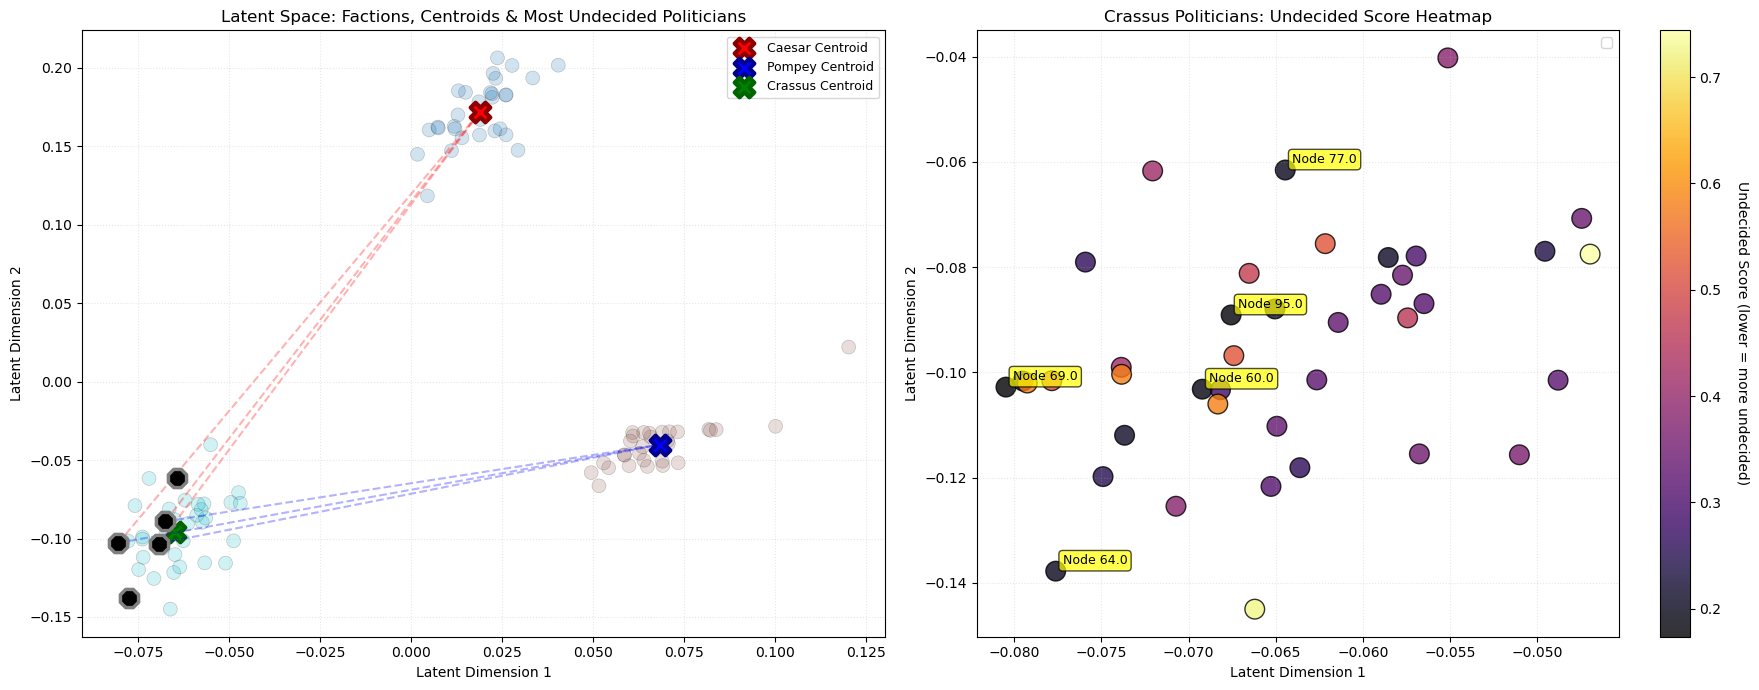

Legend (additional information):
Left plot:
  - Red X = Caesar faction center, Blue X = Pompey faction center
  - Black octagons = Most undecided politicians (balanced between factions)
Right plot ('zoomed in', heatmap):
  - Green = more undecided, Red = more decided
  - Dashed lines show equidistance to both faction centroids


In [ ]:
# Visualize latent space with faction centroids and undecided politicians
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: All politicians colored by faction with centroids
ax = axes[0]
scatter = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=faction_colors, s=100, 
                     cmap='tab10', alpha=0.2, edgecolors='black', linewidth=0.5)

# Plot faction centroids as large markers
ax.scatter(*caesar_centroid, s=200, marker='X', c='red', edgecolors='darkred', linewidth=3, 
          label='Caesar Centroid', zorder=5)
ax.scatter(*pompey_centroid, s=200, marker='X', c='blue', edgecolors='darkblue', linewidth=3, 
          label='Pompey Centroid', zorder=5)
ax.scatter(*crassus_centroid, s=200, marker='X', c='green', edgecolors='darkgreen', linewidth=3, 
          label='Crassus Centroid')

# Highlight top 5 most undecided politicians
top_undecided = undecided_df.head(5)
for idx, row in top_undecided.iterrows():
    node = row['node']
    node_idx = node_to_idx[node]
    ax.scatter(z_2d[node_idx, 0], z_2d[node_idx, 1], s=200, marker='8', 
              c='black', edgecolors='grey', linewidth=2.5, zorder=4)
    # ax.annotate(f"Node {node}", (z_2d[node_idx, 0], z_2d[node_idx, 1]), 
    #            xytext=(5, 5), textcoords='offset points', fontsize=9, 
    #            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Draw lines from top undecided to both centroids
for idx, row in top_undecided.head(3).iterrows():
    node = row['node']
    node_idx = node_to_idx[node]
    node_pos = z_2d[node_idx]
    
    ax.plot([node_pos[0], caesar_centroid[0]], [node_pos[1], caesar_centroid[1]],
            'r--', alpha=0.3, linewidth=1.5)
    ax.plot([node_pos[0], pompey_centroid[0]], [node_pos[1], pompey_centroid[1]], 
            'b--', alpha=0.3, linewidth=1.5)

ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Latent Space: Factions, Centroids & Most Undecided Politicians')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3, linestyle=':')

# Plot 2: Crassus politicians colored by undecided score
ax = axes[1]
crassus_embeddings = z_posterior[crassus_indices]
undecided_scores = undecided_df.set_index('node').loc[crassus_nodes]['undecided_score'].values

scatter2 = ax.scatter(crassus_embeddings[:, 0], crassus_embeddings[:, 1], 
                      c=undecided_scores, s=200, cmap='inferno', 
                      alpha=0.8, edgecolors='black', linewidth=1)
cbar = plt.colorbar(scatter2, ax=ax)
cbar.set_label('Undecided Score (lower = more undecided)', rotation=270, labelpad=20)

# # Add centroids
# ax.scatter(*caesar_centroid, s=600, marker='X', c='red', edgecolors='darkred', linewidth=3, 
#           label='Caesar', zorder=5)
# ax.scatter(*pompey_centroid, s=600, marker='X', c='blue', edgecolors='darkblue', linewidth=3, 
#           label='Pompey', zorder=5)

# Annotate top 5 undecided
top_undecided = undecided_df.head(5)
for idx, row in top_undecided.iterrows():
    node = row['node']
    node_idx = node_to_idx[node]
    # ax.scatter(z_2d[node_idx, 0], z_2d[node_idx, 1], s=400, edgecolors='orange', c ='clear', linewidth=2.5, zorder=4)
    ax.annotate(f"Node {node}", (z_2d[node_idx, 0], z_2d[node_idx, 1]), 
               xytext=(5, 5), textcoords='offset points', fontsize=9, 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Crassus Politicians: Undecided Score Heatmap')
ax.legend()
ax.grid(alpha=0.3, linestyle=':')

plt.tight_layout()
plt.show()

print("Legend (additional information):")
print("Left plot:")
print("  - Red X = Caesar faction center, Blue X = Pompey faction center")
print("  - Black octagons = Most undecided politicians (balanced between factions)")
print("Right plot ('zoomed in', heatmap):")
print("  - Green = more undecided, Red = more decided")
print("  - Dashed lines show equidistance to both faction centroids")

### How the "meetings" edge attribute helps answer Q2

The **meetings** attribute is crucial for identifying truly undecided politicians:

1. **Weighted Model**: By modeling `meetings` with a Poisson likelihood (not just binary edges), politicians with high meeting volumes are more influential in the latent space positioning

2. **Meeting Balance Metric**: We measure not just *number of connections* but *total meetings* to each faction:
   - A politician with 2 connections to Caesar (5 meetings each = 10 total) vs 5 connections to Pompey (1 meeting each = 5 total) is actually **more engaged with Caesar** despite fewer connections
   
3. **Weighted Indecision Score**: Our composite score combines:
   - **Distance balance** (40%): Equidistant from faction centroids in latent space
   - **Connection balance** (30%): Similar number of relationships to both factions  
   - **Meeting balance** (30%): Similar **communication volume** to both factions
   
4. **Latent Space Interpretation**: The weighted model places politicians with **high meeting volumes** closer together, so the latent space naturally reflects communication intensity, not just network topology

**Key Insight**: A politician might have many connections to one faction but few meetings (weak ties), while having fewer connections to the other faction but many meetings (strong ties). The `meetings` attribute captures this **strength of relationship**, making our undecided politician identification more accurate.